In [1]:
import pickle, tensorflow as tf, numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    SpatialDropout1D,
    Bidirectional,
    LSTM,
    TimeDistributed,
    Dense,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import zip_longest

2025-05-12 02:34:48.724737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 02:34:48.725382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 02:34:48.727445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 02:34:48.733495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746992088.743638   16048 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746992088.74

In [2]:
data = []
# with open("../dataset/new_ner_srl.tsv", encoding="utf-8") as f:
with open("../dataset/ner_srl_without_bio.tsv", encoding="utf-8") as f:
    tok, ner, srl = [], [], []
    for line in f:
        line = line.strip()
        if not line:
            if tok:
                data.append({"tokens": tok, "labels_ner": ner, "labels_srl": srl})
                tok, ner, srl = [], [], []
        else:
            t, n, s = line.split("\t")
            tok.append(t.lower())
            ner.append(n.strip())
            srl.append(s.strip())

print("total kalimat ", len(data))
# ——————————————————
sentences = [d["tokens"] for d in data]
labels_ner = [d["labels_ner"] for d in data]
labels_srl = [d["labels_srl"] for d in data]

ner_counter = Counter(label for seq in labels_ner for label in seq)

srl_counter = Counter(label for seq in labels_srl for label in seq)


print(f"{'NER Label':<15} {'Count':<10} || {'SRL Label':<15} {'Count':<10}")
print("-" * 55)

for (ner_label, ner_count), (srl_label, srl_count) in zip_longest(ner_counter.items(), srl_counter.items(), fillvalue=('', '')):
    print(f"{ner_label:<15} {ner_count:<10} || {srl_label:<15} {srl_count:<10}")

total kalimat  638
NER Label       Count      || SRL Label       Count     
-------------------------------------------------------
O               4251       || O               2178      
TIME            235        || ARGM-TMP        1291      
PER             539        || ARG0            962       
LOC             586        || V               737       
DATE            985        || ARG1            1305      
ETH             430        || ARGM-LOC        503       
EVENT           125        || ARG2            292       
MISC            17         || ARGM-MOD        39        
ORG             37         || ARGM-MNR        37        
QUANT           47         || ARGM-NEG        6         
MAT             115        || ARGM-DIR        41        
UNIT            45         || ARGM-CAU        21        


In [3]:


def calculate_o_percentage(labels):
    counter = Counter(label for seq in labels for label in seq)
    total = sum(counter.values())
    count_o = counter.get("O", 0)
    percent_o = (count_o / total) * 100 if total > 0 else 0
    return percent_o, total, count_o

# Hitung persentase 'O' untuk NER
o_ner_percent, total_ner, o_ner_count = calculate_o_percentage(labels_ner)

# Hitung persentase 'O' untuk SRL
o_srl_percent, total_srl, o_srl_count = calculate_o_percentage(labels_srl)

print(f"NER  -> Total Labels: {total_ner}, O Count: {o_ner_count}, O Percentage: {o_ner_percent:.2f}%")
print(f"SRL  -> Total Labels: {total_srl}, O Count: {o_srl_count}, O Percentage: {o_srl_percent:.2f}%")


NER  -> Total Labels: 7412, O Count: 4251, O Percentage: 57.35%
SRL  -> Total Labels: 7412, O Count: 2178, O Percentage: 29.38%


In [4]:
PAD_TOKEN = "<PAD>"
words = sorted({w for s in sentences for w in s})

ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

ner_tags.insert(0, PAD_TOKEN)
srl_tags.insert(0, PAD_TOKEN)

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

In [5]:
X = [[word2idx.get(w, 1) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = max(map(len, X))
pad_id = tag2idx_ner[PAD_TOKEN]

X = pad_sequences(X, maxlen=maxlen, padding="post", value=0)
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=pad_id)
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=pad_id)

mask = (y_ner != pad_id).astype("float32")

In [6]:
splits = train_test_split(
    X, y_ner, y_srl, mask, test_size=0.2, random_state=42, shuffle=True
)
X_tr, X_te, ner_tr, ner_te, srl_tr, srl_te, m_tr, m_te = splits

In [7]:
embed_dim = 64
lstm_units = 64
drop_embed = 0.45
drop_lstm = 0.35

inp = Input(shape=(maxlen,), name="tokens")
emb = Embedding(len(word2idx), embed_dim, mask_zero=True, name="embed")(inp)
emb = SpatialDropout1D(drop_embed)(emb)

x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(emb)
x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(x)

ner_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
ner_out = TimeDistributed(
    Dense(len(tag2idx_ner), activation="softmax"), name="ner_output"
)(ner_head)

srl_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
srl_out = TimeDistributed(
    Dense(len(tag2idx_srl), activation="softmax"), name="srl_output"
)(srl_head)

model = Model(inp, [ner_out, srl_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss={
        "ner_output": "sparse_categorical_crossentropy",
        "srl_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "ner_output": ["sparse_categorical_accuracy"],
        "srl_output": ["sparse_categorical_accuracy"],
    },
    # sample_weight_mode="temporal"
)
model.summary()

2025-05-12 02:34:51.102561: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 34)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 34, 64)    │     86,208 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 34, 64)    │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ tokens[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 34, 128)   │     66,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 34, 128)   │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 34, 64)    │      8,256 │ bidirectional_1[… │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 34, 64)    │      8,256 │ bidirectional_1[… │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 34, 13)    │        845 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 34, 13)    │        845 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 269,274 (1.03 MB)

 Trainable params: 269,274 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    X_tr,
    [ner_tr, srl_tr],  # y → LIST (pos 0 = ner_output, 1 = srl_output)
    sample_weight=[m_tr, m_tr],  # sama‑persis urutan
    validation_data=(X_te, [ner_te, srl_te], [m_te, m_te]),
    
    batch_size=64,
    epochs=30,
    callbacks=callbacks,
    verbose=1,
)


# =========================
# 7.  Save artefacts
# =========================
model.save("lstm_ner_srl_model.keras")
for fname, obj in [
    ("word2idx.pkl", word2idx),
    ("tag2idx_ner.pkl", tag2idx_ner),
    ("tag2idx_srl.pkl", tag2idx_srl),
]:
    with open(fname, "wb") as f:
        pickle.dump(obj, f)

Epoch 1/30


2025-05-12 02:34:58.809821: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 5.1207 - ner_output_loss: 2.5598 - ner_output_sparse_categorical_accuracy: 0.2926 - srl_output_loss: 2.5609 - srl_output_sparse_categorical_accuracy: 0.2646 - val_loss: 5.0921 - val_ner_output_loss: 2.5409 - val_ner_output_sparse_categorical_accuracy: 0.2015 - val_srl_output_loss: 2.5512 - val_srl_output_sparse_categorical_accuracy: 0.1043 - learning_rate: 3.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.0802 - ner_output_loss: 2.5334 - ner_output_sparse_categorical_accuracy: 0.1957 - srl_output_loss: 2.5467 - srl_output_sparse_categorical_accuracy: 0.0940 - val_loss: 5.0274 - val_ner_output_loss: 2.4995 - val_ner_output_sparse_categorical_accuracy: 0.2015 - val_srl_output_loss: 2.5279 - val_srl_output_sparse_categorical_accuracy: 0.1165 - learning_rate: 3.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5.0040 - ner_output_loss: 2.4842 - ner_output_sparse_categorical_accuracy: 0.1962 - srl_output_loss

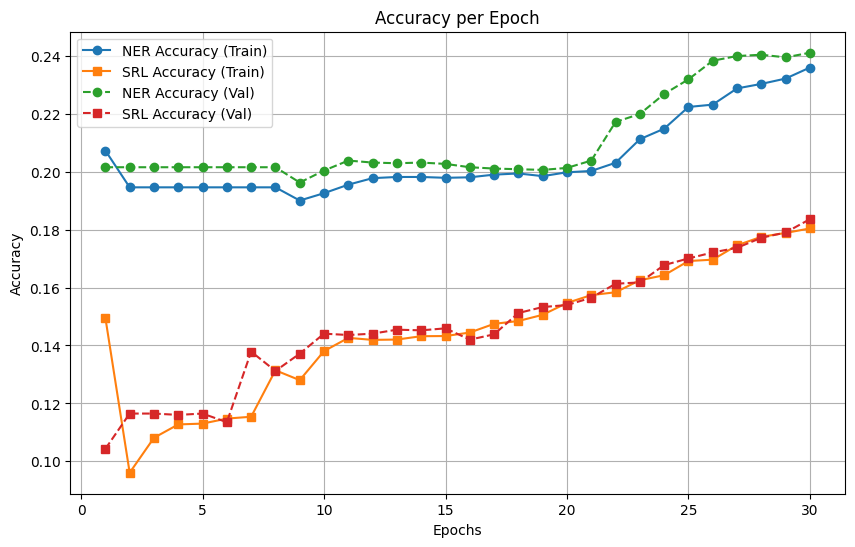

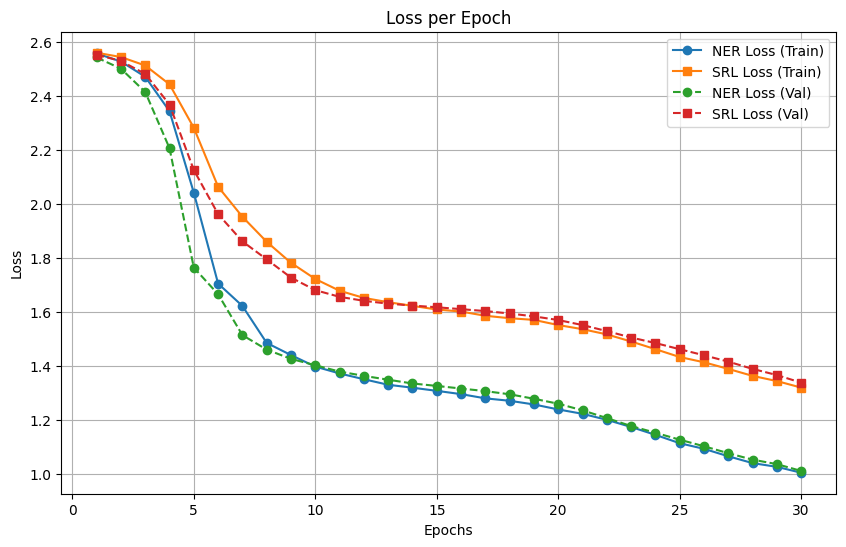

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    history_data = history.history
    epochs = range(1, len(next(iter(history_data.values()))) + 1)

    # Coba deteksi metric secara dinamis agar fleksibel
    ner_acc_key = next((k for k in history_data if "ner_output" in k and "accuracy" in k), None)
    srl_acc_key = next((k for k in history_data if "srl_output" in k and "accuracy" in k), None)
    val_ner_acc_key = f"val_{ner_acc_key}" if ner_acc_key else None
    val_srl_acc_key = f"val_{srl_acc_key}" if srl_acc_key else None

    # --- Plot Accuracy ---
    plt.figure(figsize=(10, 6))
    if ner_acc_key:
        plt.plot(epochs, history_data[ner_acc_key], marker="o", label="NER Accuracy (Train)")
    if srl_acc_key:
        plt.plot(epochs, history_data[srl_acc_key], marker="s", label="SRL Accuracy (Train)")
    if val_ner_acc_key in history_data:
        plt.plot(epochs, history_data[val_ner_acc_key], marker="o", linestyle="--", label="NER Accuracy (Val)")
    if val_srl_acc_key in history_data:
        plt.plot(epochs, history_data[val_srl_acc_key], marker="s", linestyle="--", label="SRL Accuracy (Val)")

    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    plt.show()

    # --- Plot Loss ---
    plt.figure(figsize=(10, 6))
    if "ner_output_loss" in history_data:
        plt.plot(epochs, history_data["ner_output_loss"], marker="o", label="NER Loss (Train)")
    if "srl_output_loss" in history_data:
        plt.plot(epochs, history_data["srl_output_loss"], marker="s", label="SRL Loss (Train)")
    if "val_ner_output_loss" in history_data:
        plt.plot(epochs, history_data["val_ner_output_loss"], marker="o", linestyle="--", label="NER Loss (Val)")
    if "val_srl_output_loss" in history_data:
        plt.plot(epochs, history_data["val_srl_output_loss"], marker="s", linestyle="--", label="SRL Loss (Val)")

    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()


plot_training_history(history)

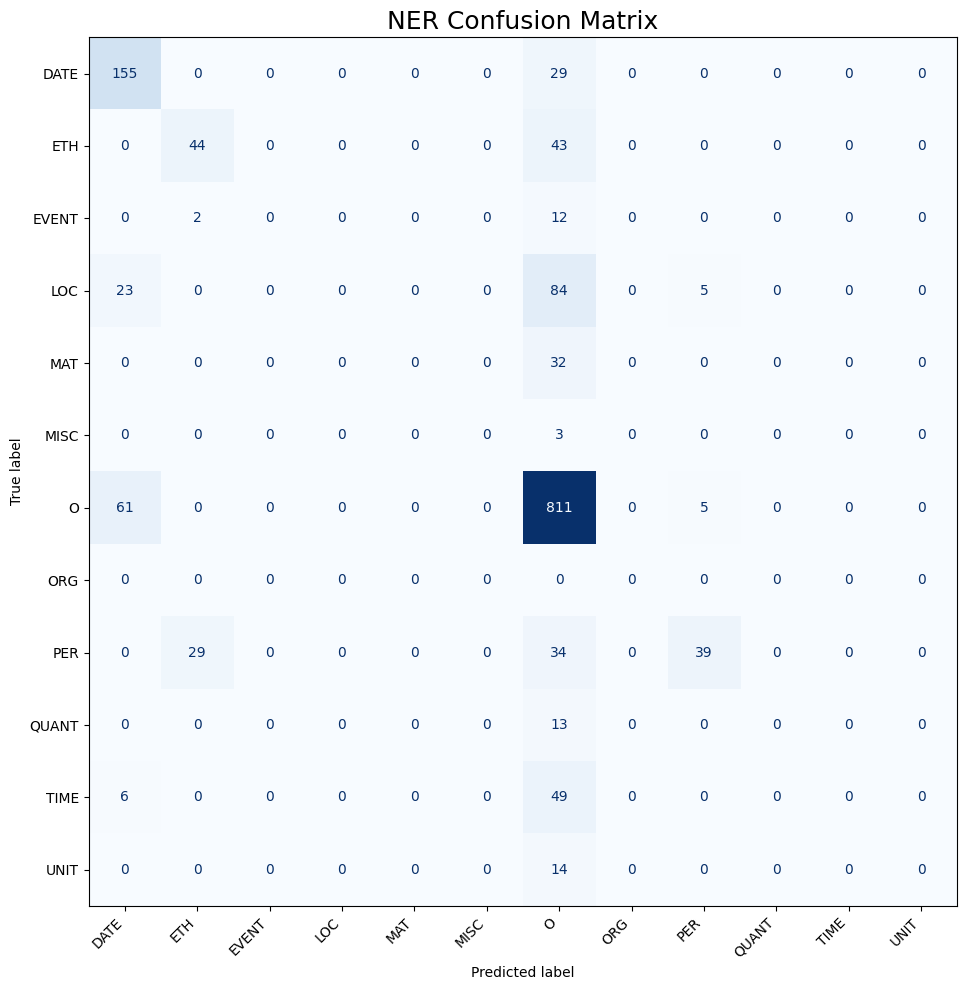

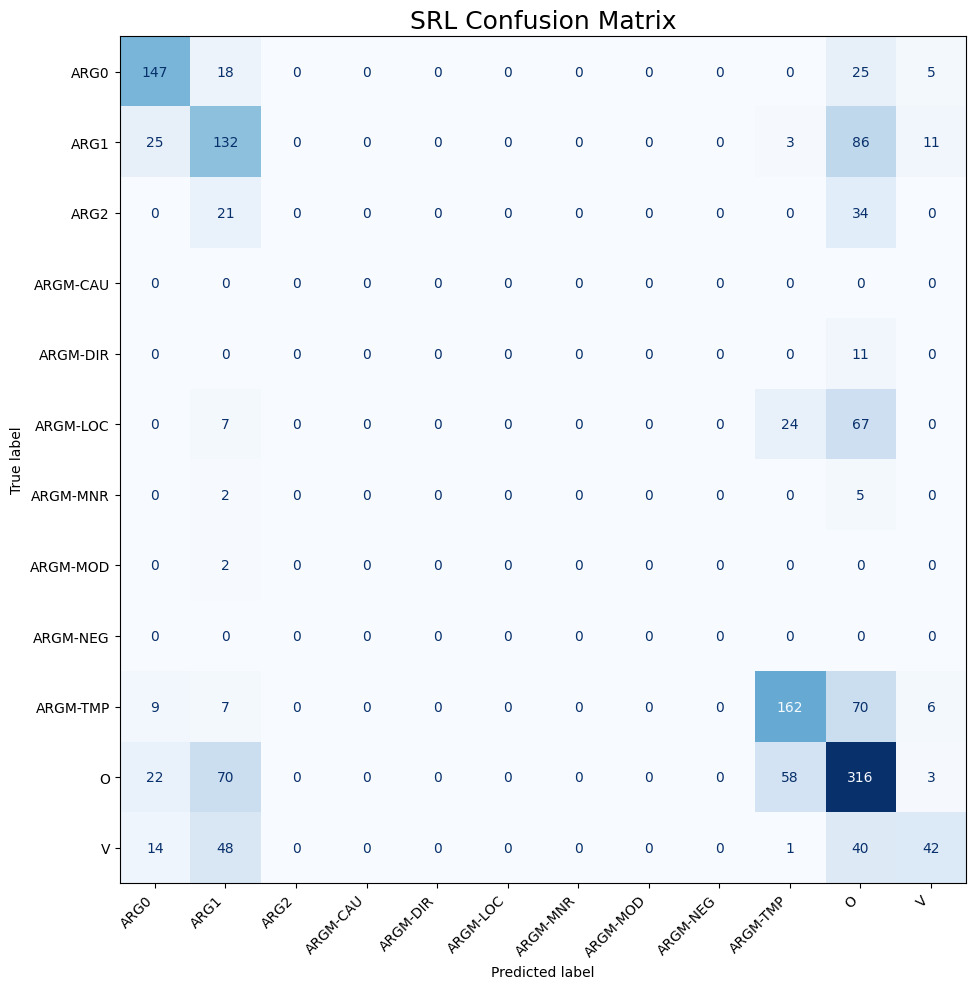

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------------------
# 1.  Prediksi
# ------------------------------------------------------------------
pred_ner_prob, pred_srl_prob = model.predict(X_te, verbose=0)

pred_ner = pred_ner_prob.argmax(-1)
pred_srl = pred_srl_prob.argmax(-1)

# ------------------------------------------------------------------
# 2.  Siapkan masker PAD
# ------------------------------------------------------------------
pad_id = tag2idx_ner["<PAD>"]

mask_ner = ner_te != pad_id
mask_srl = srl_te != pad_id

true_ner_flat = ner_te[mask_ner]
pred_ner_flat = pred_ner[mask_ner]

true_srl_flat = srl_te[mask_srl]
pred_srl_flat = pred_srl[mask_srl]

# ------------------------------------------------------------------
# 3.  Hitung confusion matrix TANPA PAD
# ------------------------------------------------------------------
# Buang ID PAD dari label list
labels_ner_no_pad = [i for i in range(len(tag2idx_ner)) if i != pad_id]
labels_srl_no_pad = [i for i in range(len(tag2idx_srl)) if i != pad_id]

cm_ner = confusion_matrix(true_ner_flat, pred_ner_flat, labels=labels_ner_no_pad)

cm_srl = confusion_matrix(true_srl_flat, pred_srl_flat, labels=labels_srl_no_pad)

# Siapkan label display TANPA PAD
display_labels_ner = [idx2tag_ner[i] for i in labels_ner_no_pad]
display_labels_srl = [idx2tag_srl[i] for i in labels_srl_no_pad]

# ------------------------------------------------------------------
# 4.  Plot NER CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_ner = ConfusionMatrixDisplay(
    confusion_matrix=cm_ner, display_labels=display_labels_ner
)
disp_ner.plot(
    include_values=True,  # Tampilkan angka
    values_format="d",  # Format integer
    cmap=plt.cm.Blues,  # Biru-putih
    ax=ax,
    colorbar=False,
)
ax.set_title("NER Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5.  Plot SRL CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_srl = ConfusionMatrixDisplay(
    confusion_matrix=cm_srl, display_labels=display_labels_srl
)
disp_srl.plot(
    include_values=True, values_format="d", cmap=plt.cm.Blues, ax=ax, colorbar=False
)
ax.set_title("SRL Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------------
# 3b.  Akurasi token‑level (tanpa PAD)
# ------------------------------------------------------------------
acc_ner = accuracy_score(true_ner_flat, pred_ner_flat)
acc_srl = accuracy_score(true_srl_flat, pred_srl_flat)

print(f"NER TAG accuracy : {acc_ner:.2%}")
print(f"SRL TAG accuracy : {acc_srl:.2%}")

NER TAG accuracy : 70.26%
SRL TAG accuracy : 53.52%


In [12]:
# (Opsional) tampilkan ringkasan metrik per‑label
print("\n[NER] Classification report:")
print(
    classification_report(
        true_ner_flat,
        pred_ner_flat,
        labels=labels_ner_no_pad,
        target_names=display_labels_ner,
        digits=2,
    )
)


[NER] Classification report:
              precision    recall  f1-score   support

        DATE       0.63      0.84      0.72       184
         ETH       0.59      0.51      0.54        87
       EVENT       0.00      0.00      0.00        14
         LOC       0.00      0.00      0.00       112
         MAT       0.00      0.00      0.00        32
        MISC       0.00      0.00      0.00         3
           O       0.72      0.92      0.81       877
         ORG       0.00      0.00      0.00         0
         PER       0.80      0.38      0.52       102
       QUANT       0.00      0.00      0.00        13
        TIME       0.00      0.00      0.00        55
        UNIT       0.00      0.00      0.00        14

    accuracy                           0.70      1493
   macro avg       0.23      0.22      0.22      1493
weighted avg       0.59      0.70      0.63      1493



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [13]:
print("\n[SRL] Classification report:")
print(
    classification_report(
        true_srl_flat,
        pred_srl_flat,
        labels=labels_srl_no_pad,
        target_names=display_labels_srl,
        digits=2,
    )
)


[SRL] Classification report:
              precision    recall  f1-score   support

        ARG0       0.68      0.75      0.71       195
        ARG1       0.43      0.51      0.47       257
        ARG2       0.00      0.00      0.00        55
    ARGM-CAU       0.00      0.00      0.00         0
    ARGM-DIR       0.00      0.00      0.00        11
    ARGM-LOC       0.00      0.00      0.00        98
    ARGM-MNR       0.00      0.00      0.00         7
    ARGM-MOD       0.00      0.00      0.00         2
    ARGM-NEG       0.00      0.00      0.00         0
    ARGM-TMP       0.65      0.64      0.65       254
           O       0.48      0.67      0.56       469
           V       0.63      0.29      0.40       145

    accuracy                           0.54      1493
   macro avg       0.24      0.24      0.23      1493
weighted avg       0.49      0.54      0.50      1493



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [14]:
# def plot_training_history(history):
#     epochs = range(1, len(history['loss']) + 1)

#     plt.figure(figsize=(14, 6))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, history['loss'], label='Training Loss')
#     plt.plot(epochs, history['val_loss'], label='Validation Loss')
#     plt.title('Loss During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot Accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, history['ner_output_accuracy'], label='NER Train Acc')
#     plt.plot(epochs, history['val_ner_output_accuracy'], label='NER Val Acc')
#     plt.plot(epochs, history['srl_output_accuracy'], label='SRL Train Acc')
#     plt.plot(epochs, history['val_srl_output_accuracy'], label='SRL Val Acc')
#     plt.title('Accuracy During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# plot_training_history(history.history)

In [15]:
# def token_level_accuracy(y_true, y_pred):
#     total, correct = 0, 0
#     for true_seq, pred_seq in zip(y_true, y_pred):
#         for t, p in zip(true_seq, pred_seq):
#             if t.sum() == 0:
#                 continue
#             total += 1
#             if t.argmax() == p.argmax():
#                 correct += 1
#     return correct / total

# def decode_predictions(pred, true, idx2tag):
#     true_out, pred_out = [], []
#     for pred_seq, true_seq in zip(pred, true):
#         t_labels, p_labels = [], []
#         for p_tok, t_tok in zip(pred_seq, true_seq):
#             if t_tok.sum() == 0:
#                 continue
#             t_labels.append(idx2tag[t_tok.argmax()])
#             p_labels.append(idx2tag[p_tok.argmax()])
#         true_out.append(t_labels)
#         pred_out.append(p_labels)
#     return true_out, pred_out

# results = model.evaluate(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}, verbose=0)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value}")

# y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

# true_ner, pred_ner = decode_predictions(y_pred_ner, y_ner_test, idx2tag_ner)
# true_srl, pred_srl = decode_predictions(y_pred_srl, y_srl_test, idx2tag_srl)

# acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
# acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

# print(f"NER Token Accuracy {acc_ner:.2%}")
# print(f"SRL Token Accuracy {acc_srl:.2%}")

In [16]:
# print("[NER] Classification Report:")
# print(classification_report(true_ner, pred_ner, digits=2))

In [17]:
# print("SRL Classification Resport:")
# print(classification_report(true_srl, pred_srl, digits=2))